In [56]:
import pandas as pd
import numpy as np
from tensorflow import keras
from BinanceCollector import BinanceCollector
from TradeBook import TradeBook
import warnings
warnings.filterwarnings("ignore")
from BreakdownCalculator import BreakdownCalculator
from BinanceSync import BinanceSync
from sklearn.model_selection import train_test_split
from tensorflow import keras
from HyperBacktest import HyperBacktest
import matplotlib.pyplot as plt
import quantstats as qs
from datetime import datetime,timedelta

In [2]:
symbol = "SOLUSDT"
collector = BinanceCollector(symbol,"2022-01-01","2023-01-02","15m")
collector.start_collect()
collector.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
df = collector.df
breakdown = BinanceCollector(symbol,"2022-01-01","2023-01-02","1m")
breakdown.start_collect()
breakdown.df.columns = ["Open Time","Open","High","Low","Close","Volume","Close Time",
             "Quote asset volumne","Total Trades","Buyer Base Volume",
             "Taker buy quote asset volume","Ignore"]
breakdown_df = breakdown.df
calculator = BreakdownCalculator(breakdown_df)

In [3]:
df["Open Time"] = pd.to_datetime(df["Open Time"],unit="ms")
df["Close Time"] = pd.to_datetime(df["Close Time"]+1,unit="ms")
open_time = df["Open Time"]

In [4]:
df["EMA_20"] = df["Close"].ewm(span=20,adjust=False).mean()
df["EMA_50"] = df["Close"].ewm(span=50,adjust=False).mean()
df["EMA_200"] = df["Close"].ewm(span=200,adjust=False).mean()

df = df[["Open","High","Low","Close","EMA_20","EMA_50","EMA_200","Open Time"]]

# Normalising Data
# df = (df - df.mean())/df.std()

In [5]:
# Filter dataframe for month
# df = df[df["Open Time"].dt.month == 4]
# df.reset_index(inplace=True)

In [6]:
df["Buy"] = np.where( (df["EMA_20"] > df["EMA_50"]) & (df["EMA_20"].shift(1) <= df["EMA_50"].shift(1) ),1,0 )
df["Sell"] = np.where( (df["EMA_20"] < df["EMA_50"]) & (df["EMA_20"].shift(1) >= df["EMA_50"].shift(1) ),1,0 )
df["Returns"] = 0

In [7]:
main = df.copy()
main.tail()

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns
34765,9.99,10.01,9.97,9.97,9.973550,9.940877,9.878851,2023-01-01 22:45:00,0,0,0
34766,9.98,10.06,9.98,10.02,9.977973,9.943980,9.880255,2023-01-01 23:00:00,0,0,0
34767,10.02,10.03,9.96,9.97,9.977214,9.945000,9.881148,2023-01-01 23:15:00,0,0,0
34768,9.97,9.99,9.96,9.98,9.977479,9.946373,9.882132,2023-01-01 23:30:00,0,0,0
34769,9.98,10.00,9.95,9.99,9.978672,9.948083,9.883205,2023-01-01 23:45:00,0,0,0


In [8]:
df = main.copy()
leverage = 1
backtest = HyperBacktest(4,-2,calculator,df,leverage=leverage)
backtest.run()
df = backtest.df
# calculate total portfolio value
start_balance = 20
df["Compounded Returns"] = (1 + df["Returns"]/100).cumprod()
df["Portfolio Value"] = df["Compounded Returns"] * start_balance
tmp = df.copy()
tmp = tmp.set_index("Open Time")
qs.reports.html(tmp["Returns"]/100, output="report.html",download_filename=f"report-{symbol}.html", title=f"Report {symbol} ({leverage}x leverage)")

From: 2022-01-01 00:30:00 
To: 2022-01-02 00:30:00
------------------
From: 2022-01-02 16:30:00 
To: 2022-01-03 16:30:00
------------------
From: 2022-01-02 23:15:00 
To: 2022-01-03 23:15:00
------------------
From: 2022-01-03 13:15:00 
To: 2022-01-04 13:15:00
------------------
From: 2022-01-04 11:30:00 
To: 2022-01-05 11:30:00
------------------
From: 2022-01-05 07:00:00 
To: 2022-01-06 07:00:00
------------------
From: 2022-01-06 18:00:00 
To: 2022-01-07 18:00:00
------------------
From: 2022-01-08 04:30:00 
To: 2022-01-09 04:30:00
------------------
From: 2022-01-08 22:30:00 
To: 2022-01-09 22:30:00
------------------
From: 2022-01-09 17:15:00 
To: 2022-01-10 17:15:00
------------------
From: 2022-01-10 05:15:00 
To: 2022-01-11 05:15:00
------------------
From: 2022-01-11 03:15:00 
To: 2022-01-12 03:15:00
------------------
From: 2022-01-11 12:30:00 
To: 2022-01-12 12:30:00
------------------
From: 2022-01-12 09:15:00 
To: 2022-01-13 09:15:00
------------------
From: 2022-01-14 18:

<AxesSubplot:>

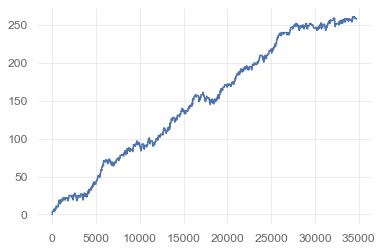

In [9]:
df["Returns"].cumsum().plot()
# df["Portfolio Value"].plot(figsize=(20,5))

Text(0.5, 1.0, 'Monthly Returns SOLUSDT (3x)')

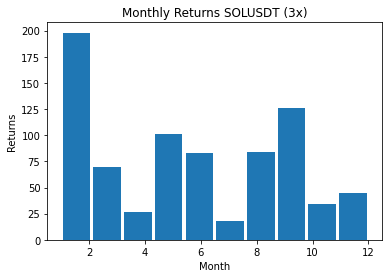

In [61]:
# Calculate monthly returns
returns = []
months = []
for i in range(1,13):
    months.append(i)
    r = df["Returns"][df["Open Time"].dt.month == i].sum()
    returns.append(r)

plt.hist(months,weights=returns,rwidth=0.9)
plt.xlabel("Month")
plt.ylabel("Returns")
plt.title(f"Monthly Returns {symbol} ({leverage}x)")

In [35]:
df.head()

,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns,Compounded Returns
0,170.85,171.39,170.73,171.14,171.140000,171.140000,171.140000,2022-01-01 00:15:00,0,0,0,1
1,171.18,171.90,171.05,171.75,171.198095,171.163922,171.146070,2022-01-01 00:30:00,1,0,4,5
2,171.74,172.57,171.54,172.38,171.310658,171.211611,171.158348,2022-01-01 00:45:00,0,0,0,5
3,172.37,172.87,171.77,172.87,171.459166,171.276646,171.175379,2022-01-01 01:00:00,0,0,0,5
4,172.86,174.30,172.73,173.73,171.675436,171.372856,171.200798,2022-01-01 01:15:00,0,0,0,5


In [29]:
df[ (df["Buy"] == 1) & (df["Returns"] < 0) ]

,index,Open,High,Low,Close,EMA_20,EMA_50,EMA_200,Open Time,Buy,Sell,Returns
307,8857,3505.14,3507.83,3502.55,3506.14,3501.574118,3501.296832,3476.249506,2022-04-04 05:45:00,1,0,-2
366,8916,3503.59,3517.10,3496.86,3516.16,3470.294027,3469.719705,3473.258521,2022-04-04 20:30:00,1,0,-1
604,9154,3220.03,3224.70,3216.22,3224.47,3215.264899,3215.258351,3308.378970,2022-04-07 08:45:00,1,0,-1
607,9157,3206.67,3230.66,3206.67,3225.37,3215.271910,3215.231805,3305.616019,2022-04-07 09:30:00,1,0,-1
723,9273,3266.93,3304.00,3261.23,3290.92,3260.327884,3259.614853,3266.898704,2022-04-08 14:45:00,1,0,-1
901,9451,3244.39,3256.38,3244.38,3251.78,3244.760490,3244.577499,3241.089215,2022-04-10 11:45:00,1,0,-1
1076,9626,3025.23,3033.68,3018.63,3031.09,3007.570776,3006.542675,3096.788943,2022-04-12 08:00:00,1,0,-1
1195,9745,3079.11,3084.00,3070.83,3081.16,3039.939688,3038.661830,3053.369081,2022-04-13 14:00:00,1,0,-1
1556,10106,3048.46,3049.00,3044.93,3046.19,3041.384669,3041.275681,3040.056740,2022-04-17 09:15:00,1,0,-2
1607,10157,3054.84,3073.74,3041.00,3072.44,3050.088614,3049.787626,3044.712445,2022-04-17 22:00:00,1,0,-1


In [71]:
# Optimizing data for profitable buy signals
x = df[ df["Buy"] == 1 ]
y = np.where( x["Returns"] > 2,1 ,0 )
x = x[["Open","High","Low","Close","EMA_20","EMA_50","EMA_200"]]

In [72]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
x_train = np.reshape( np.array(x_train), (x_train.shape[0],1,x_train.shape[1]) )
x_test = np.reshape( np.array(x_test), (x_test.shape[0],1,x_test.shape[1]) )

In [130]:
model = keras.Sequential([
    keras.layers.GRU(12,return_sequences=True,input_shape=(1,7)),
    keras.layers.Dense(8,activation="relu"),
    keras.layers.Dense(4,activation="tanh"),
    keras.layers.Dense(2),
    keras.layers.Softmax()
])

# keras.losses.c

model.compile(optimizer="ftrl",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.fit(x_train,y_train,epochs=10)

Train on 260 samples
Epoch 1/10
260/260 [==============================] - 2s 6ms/sample - loss: 0.7050 - acc: 0.7188
Epoch 2/10
260/260 [==============================] - 0s 200us/sample - loss: 0.6902 - acc: 0.8046
Epoch 3/10
260/260 [==============================] - 0s 169us/sample - loss: 0.6890 - acc: 0.8046
Epoch 4/10
260/260 [==============================] - 0s 169us/sample - loss: 0.6879 - acc: 0.8012
Epoch 5/10
260/260 [==============================] - 0s 192us/sample - loss: 0.6870 - acc: 0.8012
Epoch 6/10
260/260 [==============================] - 0s 181us/sample - loss: 0.6861 - acc: 0.8012
Epoch 7/10
260/260 [==============================] - 0s 181us/sample - loss: 0.6854 - acc: 0.8080
Epoch 8/10
260/260 [==============================] - 0s 173us/sample - loss: 0.6848 - acc: 0.8012
Epoch 9/10
260/260 [==============================] - 0s 154us/sample - loss: 0.6841 - acc: 0.8080
Epoch 10/10
260/260 [==============================] - 0s 165us/sample - loss: 0.6836 - ac

In [131]:
model.evaluate(x_test,y_test)

65/65 [==============================] - 1s 23ms/sample - loss: 0.6849 - acc: 0.7653


[0.684859459216778, 0.76525134]

In [138]:
tmp = x_train[3]
tmp_r = y_train[3]
tmp = np.reshape(tmp,(1,1,7))

In [139]:
model.predict(tmp)

array([[[0.50829697, 0.491703  ]]], dtype=float32)

In [29]:
df = df.set_index("Open Time")
# df = df[ df["Returns"] != 0 ]

In [32]:
qs.reports.html(df["Returns"]/100, output="report.html",download_filename=f"report-{symbol}.html", title=f"Report {symbol}")

In [93]:
trades = df[ df["Buy"] == 1 ]
trades.reset_index(inplace=True)

In [94]:
trades["Gap"] = (trades["Open Time"] - trades["End"].shift(1).fillna(datetime.now())).apply(lambda x: x.total_seconds()/60)
trades = trades[1:]

<AxesSubplot:>

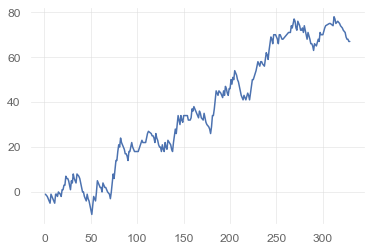

In [95]:
trades[ trades["Gap"] >= 0 ]['Returns'].cumsum().plot()